# Project 2 -  An analysis of paleo-present climate data
#### Problem Statement

> An analysis of paleo-present climate data
>
> * Analyse CO2 vs Temperature Anomaly from 800kyrs – present.
> * Examine one other (paleo/modern) features (e.g. CH4 or polar ice-coverage)
> * Examine Irish context:
>   * Climate change signals: (see Maynooth study: The emergence of a climate change signal in long-term Irish meteorological observations - ScienceDirect)
> * Fuse and analyse data from various data sources and format fused data set as a pandas dataframe and export to csv and json formats
> * For all of the above variables, analyse the data, the trends and the relationships between them (temporal leads/lags/frequency      analysis).
> * Predict global temperature anomaly over next few decades (synthesise data) and compare to published climate models if atmospheric CO2 trends continue
> * Comment on accelerated warming based on very latest features (e.g. temperature/polar-icecoverage)
>
> Use a Jupyter notebook for your analysis and track your progress using GitHub.
>
> Use an academic referencing style


The following libraries are required for this project.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import netCDF4
from netCDF4 import Dataset
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Working with Excel Files
***
Install xlrd in anaconda to allow pandas to read .xls files\
use the following command: conda install -c anaconda xlrd[6]\
Install netCDF4 for sea ice data\
use the following command: conda install -c conda-forge netCDF4[7]

I have shown an example of this code which I used to download the data below, but I have commented it out so that the Jupyter Notebook will run on machines that don't have these packages installed.

In [2]:
# Example of how to download xl files and create csv files

# CO2 data from Luethi et al. 2008 Nature Paper
'''
Sheet1 = 'data/csv_files/2008_nature_new_CO2_data.csv'
Sheet2 = 'data/csv_files/2008_nature_Vostok_TD_Dome_C.csv'
Sheet3 = 'data/csv_files/2008_nature_Composite_CO2.csv'

url = 'data/41586_2008_BFnature06949_MOESM31_ESM.xls'

df1=pd.read_excel(url, '1.  new CO2 data')
df2=pd.read_excel(url, '2.  Vostok-TD-Dome C')
df3=pd.read_excel(url, '3.  Composite CO2')

# tidy up the file
df3 = pd.DataFrame().assign(nature_year =df3['Composite CO2 record (0-800 kyr BP)'], nature_co2_ppmv = df3['Unnamed: 1'])
df3 = df3.drop(labels=range(0,6), axis=0)

df1.to_csv(Sheet1, index = False)
df2.to_csv(Sheet2, index = False)
df3.to_csv(Sheet3, index = False)
'''

"\nSheet1 = 'data/csv_files/2008_nature_new_CO2_data.csv'\nSheet2 = 'data/csv_files/2008_nature_Vostok_TD_Dome_C.csv'\nSheet3 = 'data/csv_files/2008_nature_Composite_CO2.csv'\n\nurl = 'data/41586_2008_BFnature06949_MOESM31_ESM.xls'\n\ndf1=pd.read_excel(url, '1.  new CO2 data')\ndf2=pd.read_excel(url, '2.  Vostok-TD-Dome C')\ndf3=pd.read_excel(url, '3.  Composite CO2')\n\n# tidy up the file\ndf3 = pd.DataFrame().assign(nature_year =df3['Composite CO2 record (0-800 kyr BP)'], nature_co2_ppmv = df3['Unnamed: 1'])\ndf3 = df3.drop(labels=range(0,6), axis=0)\n\ndf1.to_csv(Sheet1, index = False)\ndf2.to_csv(Sheet2, index = False)\ndf3.to_csv(Sheet3, index = False)\n"

## Greenhouse Gases & Global Warming
***
Greenhouse gases (GHGs) play a crucial role in regulating Earth's climate. The Greenhouse Effect is where GHGs, such as CO<sub>2</sub>, CH<sub>4</sub>, and H<sub>2</sub>O, trap heat in the Earth's atmosphere, similar to how a greenhouse retains heat. Human activities, especially the burning of fossil fuels and deforestation, have significantly increased the concentration of GHGs in the atmosphere. This enhanced greenhouse effect leads to increased global temperatures, a phenomenon known as global warming[1].
As the planet warms, it disrupts weather patterns, leading to more frequent and severe weather events like hurricanes, droughts, and heavy rainfall [2]. Melting  ice caps at the poles and glaciers, partly due to increasing temperatures, contributes to rising sea levels which threatens coastal regions[3]. Therefore, while GHGs are essential for maintaining Earth's temperature, their concentrations have been greatly increased by human activities leading to adverse effects on the climate and environment.

#### The Keeling Curve
Chemist Charles Keeling started measuring CO<sub>2</sub> levels in 1955 and in 1958 he began taking measurements at Mauna Loa in Hawaii which continues until today. He noted that CO<sub>2</sub> levels were rising and by 2008 had noted an increase from 315 ppm to 380 ppm[4]. This data[5] has become known as the Keeling Curve and is plotted below. This curve is an important dataset in climate science as it highlights the rapid changes in atmospheric CO<sub>2</sub>. 

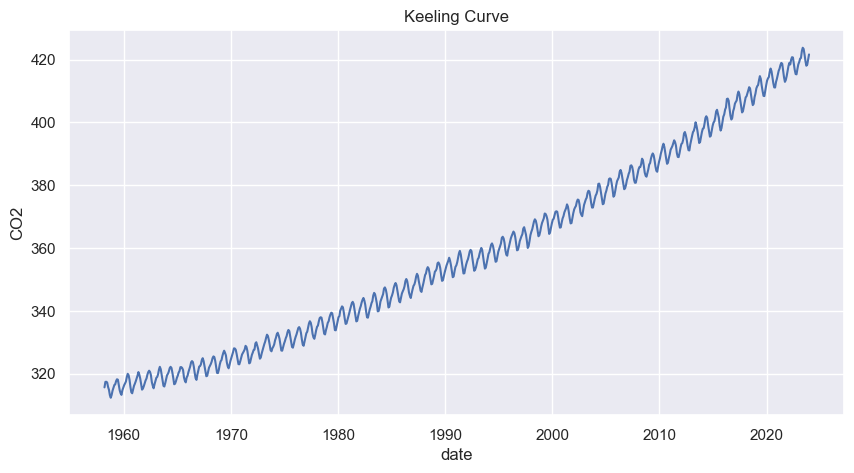

In [3]:
df_mlo=pd.read_csv('data/csv_files/monthly_in_situ_co2_mlo.csv')

plt.style.use('ggplot')
sns.set(rc = {'figure.figsize':(10, 5)})

sns.lineplot(x = 'date', y = 'CO2', data=df_mlo).set( title='Keeling Curve')
plt.show()

#### Historical Carbon Dioxide Levels
Next I am going to look at paleoclimate data mainly from ice cores starting with CO<sub>2</sub>. I have replicated a plot below from a paper in Nature by Lüthi et al.[8] which shows the fluctuation in CO<sub>2</sub> levels from the present to 800 Kyr BP.

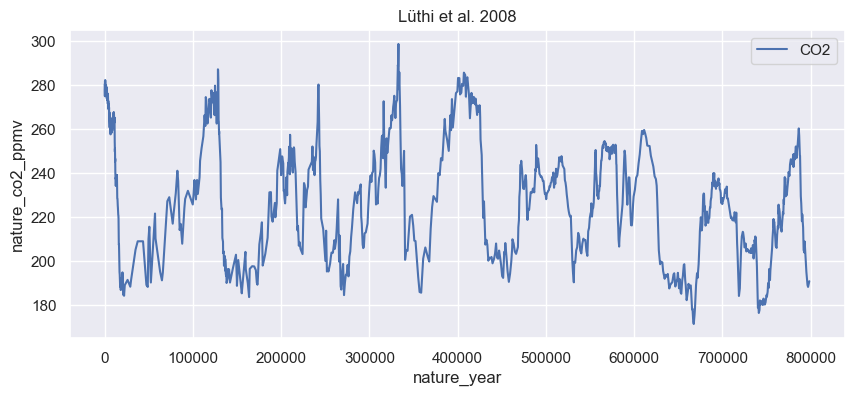

In [4]:
df3=pd.read_csv('data/csv_files/2008_nature_Composite_CO2.csv')
df = df3
sns.set(rc = {'figure.figsize':(10, 4)})
sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df, label = 'CO2').set( title='Lüthi et al. 2008')
plt.show()

Below is a plot from the Chen et al. and IPCC[9] with more recent data added.

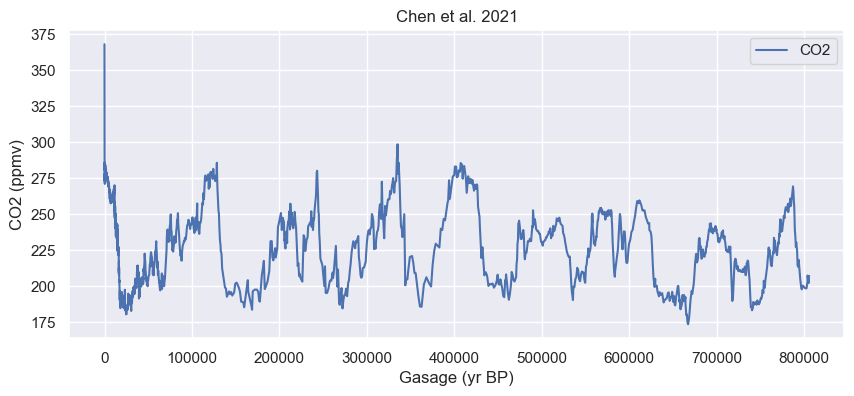

In [5]:
df4=pd.read_csv('data/csv_files/grl52461_composite_data.csv')
sns.lineplot(x = 'Gasage (yr BP)', y = 'CO2 (ppmv)', data=df4, label = 'CO2').set( title='Chen et al. 2021')
plt.show()

Comparison of both datasets

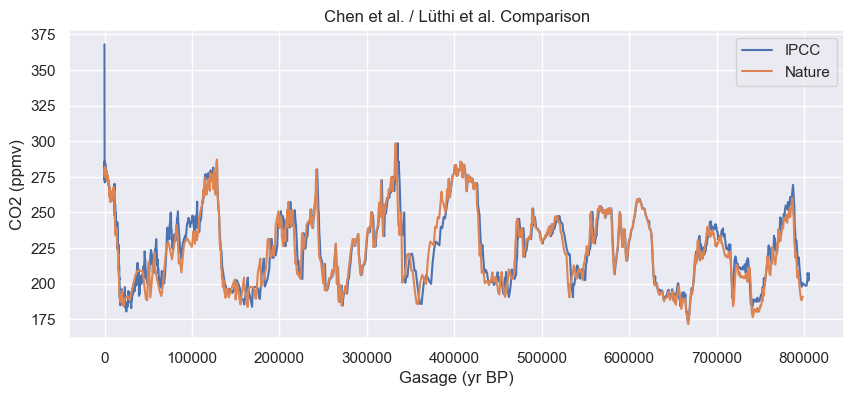

In [6]:
sns.lineplot(x = 'Gasage (yr BP)', y = 'CO2 (ppmv)', data=df4, label = 'IPCC')
sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df, label = 'Nature').set( title='Chen et al. / Lüthi et al. Comparison')

plt.show()

#### Historical Temperatures
Next I'm going to plot two temperature reconstructions, one from 2007[10] and another from 2012[11].

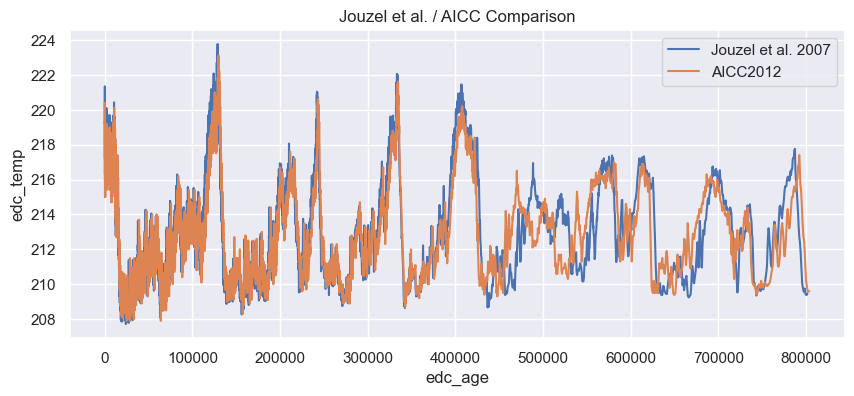

In [7]:
df5=pd.read_csv('data/csv_files/edc3deuttemp_2007.csv')
df6=pd.read_csv('data/csv_files/epicaDC_deuttemp_EDC3-AICC.csv', encoding = "ISO-8859-1")
df_temp = pd.DataFrame().assign(edc_age =df5['Age'], edc_temp_anomaly = df5['Temperature'])
df_temp.insert(2, 'epica_age', df6['EDC3béta'])
df_temp.insert(3, 'epica_temp', df6['temp'])

# Convert the temp anomaly back to degrees Kelvin
df_temp['edc_temp'] = df_temp['edc_temp_anomaly']
temp_column = df_temp['edc_temp']
def add_offset(x):
    x += 218.3
    return x
new_temp_column = temp_column.apply(add_offset)
df_temp['edc_temp'] = new_temp_column

sns.lineplot(x = 'edc_age', y = 'edc_temp', data=df_temp, label = 'Jouzel et al. 2007').set( title='Jouzel et al. / AICC Comparison')
sns.lineplot(x = 'epica_age', y = 'epica_temp', data=df_temp, label = 'AICC2012')

plt.show()

We can see some variation from about 400Ky to 800Ky but otherwise they match up.

#### Relationship between CO<sub>2</sub> and Temperature
First I will plot both sets of data one above the other

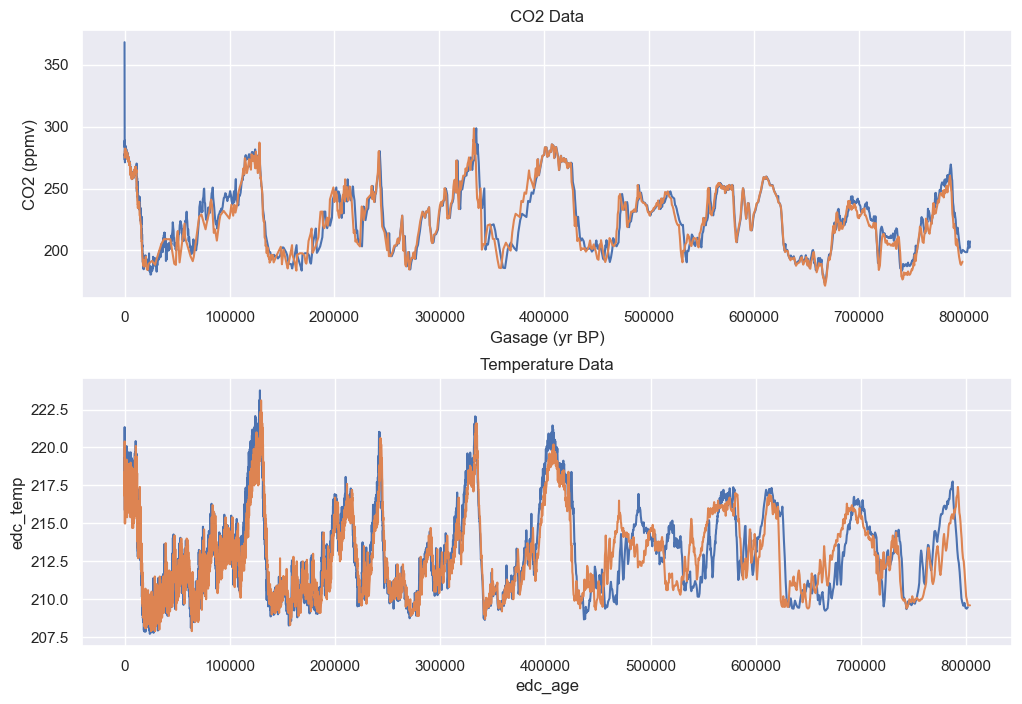

In [8]:
# co2 vs. temp
sns.set(rc = {'figure.figsize':(12, 8)})
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=False)
fig.subplots_adjust(hspace=0.3)
sns.lineplot(x = 'Gasage (yr BP)', y = 'CO2 (ppmv)', data=df4, ax = ax1).set( title='CO2 Data')
sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df, ax = ax1) 
sns.lineplot(x = 'edc_age', y = 'edc_temp', data=df_temp, ax = ax2).set( title='Temperature Data')
sns.lineplot(x = 'epica_age', y = 'epica_temp', data=df_temp, ax = ax2)
plt.show()

CO<sub>2</sub> and Temperature on the same plot

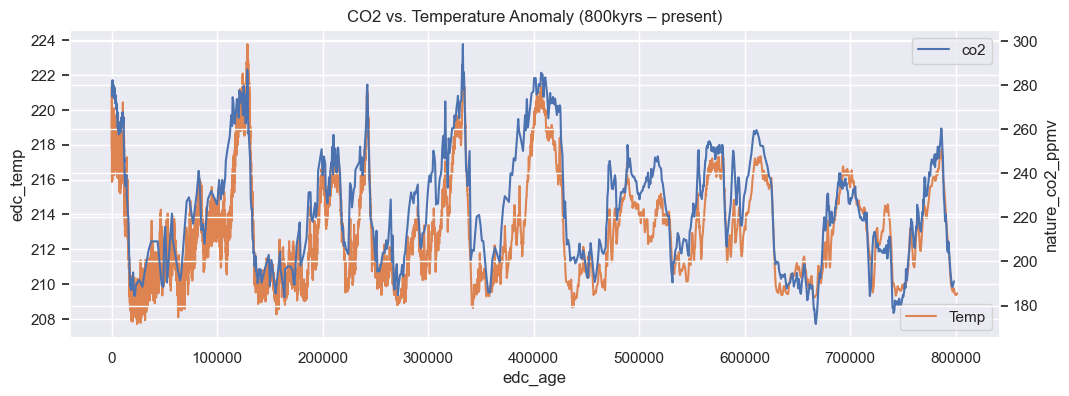

In [9]:
# co2 vs. temp overlay
sns.set(rc = {'figure.figsize':(12, 4)})
fig, (ax) = plt.subplots(nrows=1, sharex=False)

sns.lineplot(x = 'edc_age', y = 'edc_temp', data=df_temp,color='#dd8452', label = 'Temp').legend(loc=4)
ax2 = plt.twinx()
sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv', data=df, label = 'co2')

plt.title('CO2 vs. Temperature Anomaly (800kyrs – present)')
plt.show()

#### Investigate Lead/Lag between CO<sub>2</sub> and Temperature

we can see from the plot above that co2 lags temp slightly\
we will focus in on 100,000 to 400,000 years ago to get a clearer picture

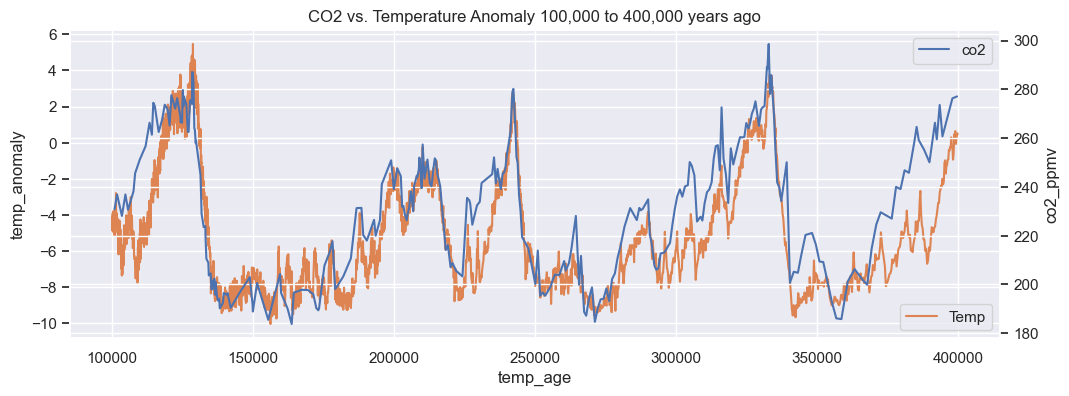

In [10]:
df_10_40k_temp = pd.DataFrame().assign(temp_age =df_temp['edc_age'], temp_anomaly = df_temp['edc_temp_anomaly'])
df_10_40k_temp = df_10_40k_temp.loc[(df_10_40k_temp['temp_age'] >= 100000) & (df_10_40k_temp['temp_age'] <= 400000)]
df_10_40k_co2 = pd.DataFrame().assign(co2_age =df['nature_year'], co2_ppmv = df['nature_co2_ppmv'])
df_10_40k_co2 = df_10_40k_co2.loc[(df_10_40k_co2['co2_age'] >= 100000) & (df_10_40k_co2['co2_age'] <= 400000)]

sns.set(rc = {'figure.figsize':(12, 4)})
fig, (ax) = plt.subplots(nrows=1, sharex=False)

sns.lineplot(x = 'temp_age', y = 'temp_anomaly', data=df_10_40k_temp, color='#dd8452', label = 'Temp').legend(loc=4)
ax2 = plt.twinx()
sns.lineplot(x = 'co2_age', y = 'co2_ppmv', data=df_10_40k_co2, label = 'co2')
plt.title('CO2 vs. Temperature Anomaly 100,000 to 400,000 years ago')

plt.show()


From this plot we see that temperature leads CO<sub>2</sub> by a little when temperature is increasing and by significantly more when it’s decreasing. I will now create two time-shifted temperature plots to show this lead during temperature increases. Then I will do the same for when temperature is decreasing.

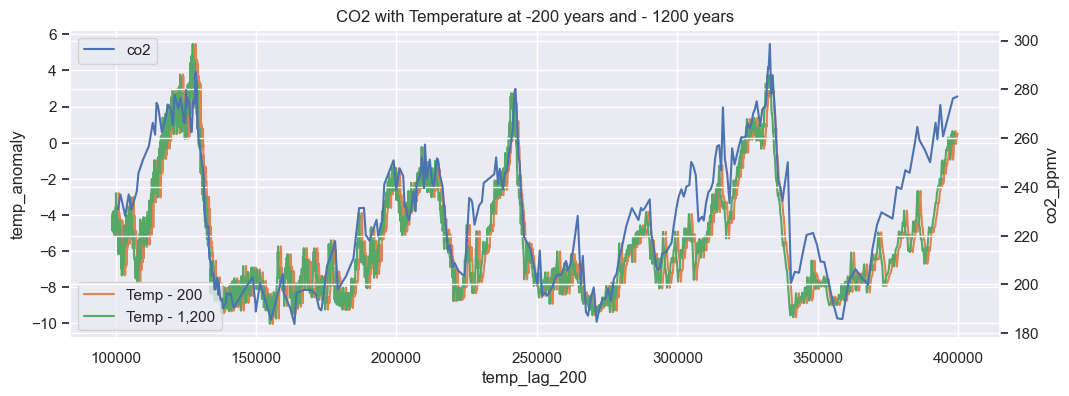

In [11]:
df_10_40k_temp['temp_lag_200'] = df_10_40k_temp['temp_age']
temp_column = df_10_40k_temp['temp_lag_200']
def add_offset(x):
    x -= 200
    return x
new_temp_column = temp_column.apply(add_offset)
df_10_40k_temp['temp_lag_200']= new_temp_column

df_10_40k_temp['temp_lag_1200'] = df_10_40k_temp['temp_age']
temp_column = df_10_40k_temp['temp_lag_1200']
def add_offset(x):
    x -= 1200
    return x
new_temp_column = temp_column.apply(add_offset)
df_10_40k_temp['temp_lag_1200']= new_temp_column

sns.lineplot(x = 'temp_lag_200', y = 'temp_anomaly', data=df_10_40k_temp, color='#dd8452', label = 'Temp - 200').legend(loc=4)
sns.lineplot(x = 'temp_lag_1200', y = 'temp_anomaly', data=df_10_40k_temp, color='#55a868', label = 'Temp - 1,200').legend(loc=3)
ax2 = plt.twinx()
sns.lineplot(x = 'co2_age', y = 'co2_ppmv', data=df_10_40k_co2, label = 'co2').legend(loc=2)
plt.title('CO2 with Temperature at -200 years and - 1200 years')

plt.show()

The above plot shows that co2 increase lags temp by between 200 and 1,200 years during times when temperatures are increasing, now we'll look at the lag when they're decreasing.

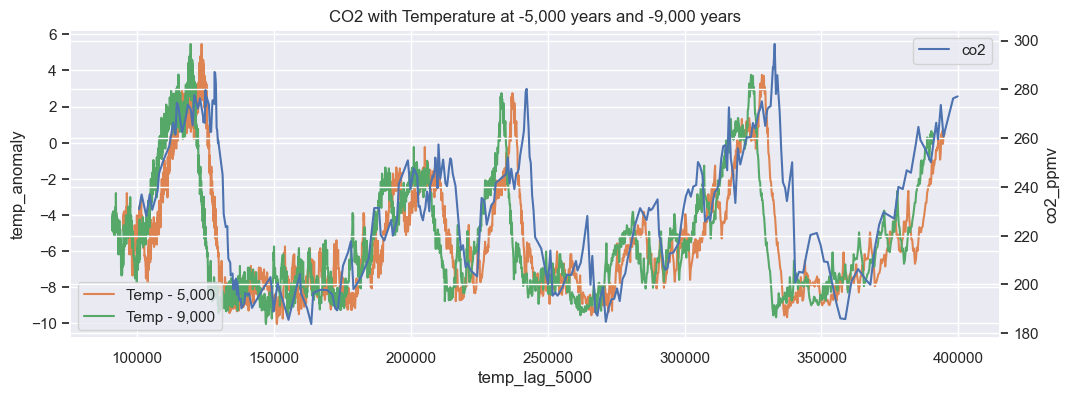

In [12]:
# For temp decrease
df_10_40k_temp['temp_lag_5000'] = df_10_40k_temp['temp_age']
temp_column = df_10_40k_temp['temp_lag_5000']
def add_offset(x):
    x -= 5000
    return x
new_temp_column = temp_column.apply(add_offset)
df_10_40k_temp['temp_lag_5000']= new_temp_column

df_10_40k_temp['temp_lag_9000'] = df_10_40k_temp['temp_age']
temp_column = df_10_40k_temp['temp_lag_9000']
def add_offset(x):
    x -= 9000
    return x
new_temp_column = temp_column.apply(add_offset)
df_10_40k_temp['temp_lag_9000']= new_temp_column

sns.lineplot(x = 'temp_lag_5000', y = 'temp_anomaly', data=df_10_40k_temp, color='#dd8452', label = 'Temp - 5,000').legend(loc=4)
sns.lineplot(x = 'temp_lag_9000', y = 'temp_anomaly', data=df_10_40k_temp, color='#55a868', label = 'Temp - 9,000').legend(loc=3)
ax2 = plt.twinx()
sns.lineplot(x = 'co2_age', y = 'co2_ppmv', data=df_10_40k_co2, label = 'co2')
plt.title('CO2 with Temperature at -5,000 years and -9,000 years')

plt.show()

These results are not as clear as the previous plot, but they show a longer lag when temp is reducing. It must be noted that while CO2 lags temperature in Antarctica at least, where these datasets were gathered this does not discount the feedback effect from CO<sub>2</sub> on the temperature increase[12].

#### Other Greenhouse Gases

Methane (CH<sub>4</sub>) is another greenhouse gas, it absorbs and emits infrared radiation, trapping heat in the Earth's atmosphere. CH<sub>2</sub>  is about 28 times more effective than CO<sub>2</sub> at trapping heat although its atmospheric concentration is much lower[13]. The plot below is CH<sub>4</sub>  data gathered by Chappellaz et al, 1990 from Antarctic Ice Cores[14].

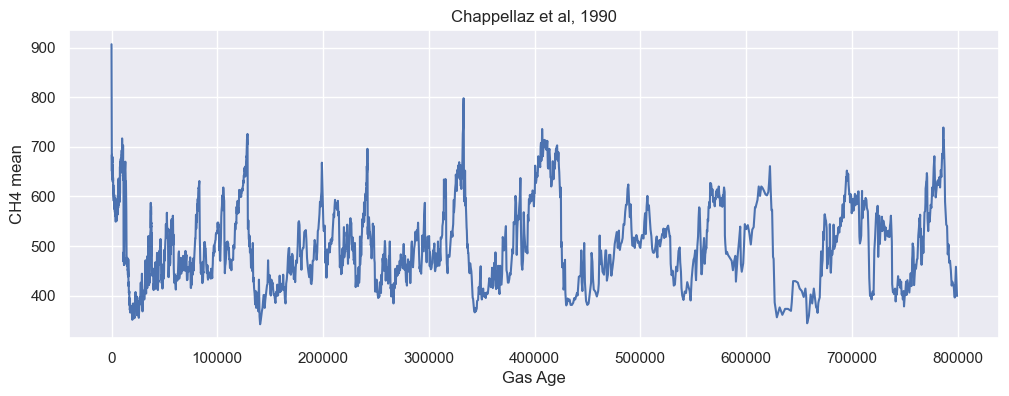

In [13]:
df_ch4=pd.read_csv('data/csv_files/edc_ch4_2008.csv')

sns.lineplot(x = 'Gas Age', y = 'CH4 mean', data=df_ch4).set( title='Chappellaz et al, 1990')
plt.show()

Check for Correlation between Methane, Carbon Dioxide and Temperature

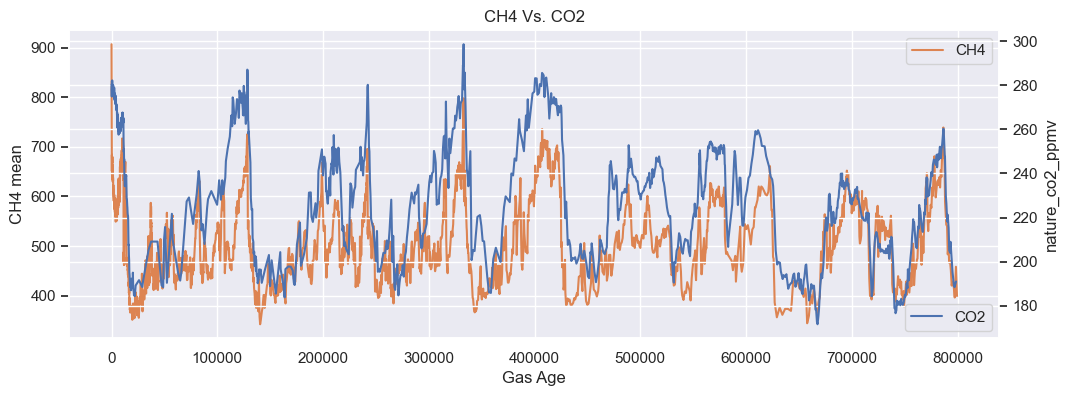

In [14]:
sns.set(rc = {'figure.figsize':(12, 4)})
fig, ax = plt.subplots(sharex=False)
sns.lineplot(x = 'Gas Age', y = 'CH4 mean', data=df_ch4, label = 'CH4',color='#dd8452')
ax = plt.twinx()
sns.lineplot(x = 'nature_year', y = 'nature_co2_ppmv',label = 'CO2', data=df).legend(loc=4)
plt.title('CH4 Vs. CO2')
plt.show()

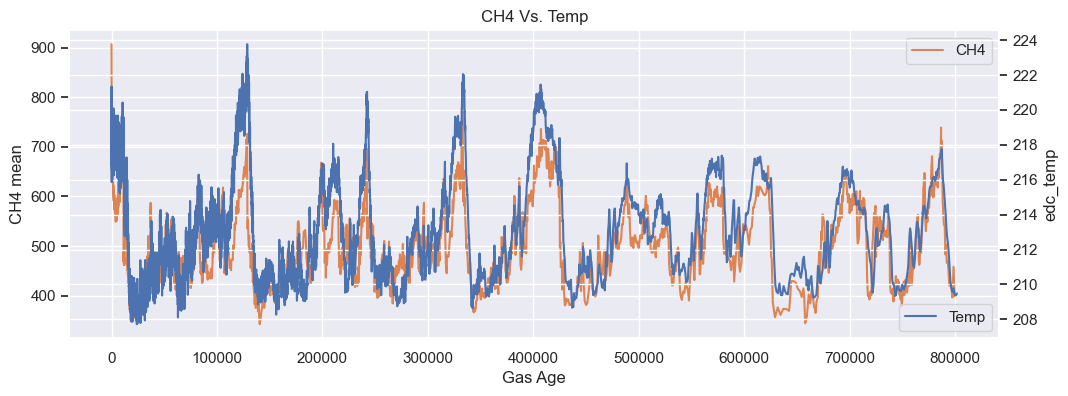

In [15]:
fig, ax = plt.subplots(sharex=False)
sns.lineplot(x = 'Gas Age', y = 'CH4 mean', data=df_ch4, label = 'CH4',color='#dd8452')
ax = plt.twinx()
sns.lineplot(x = 'edc_age', y = 'edc_temp', data=df_temp,label = 'Temp').legend(loc=4)
plt.title('CH4 Vs. Temp')
plt.show()

In both of the above plots we can see a big correlation between Methane and both Carbon Dioxide and Temperature

#### Irish Data

Below is a plot of data from Met Éireann[15] which shows rainfall in Ireland between 1700 and 2016.

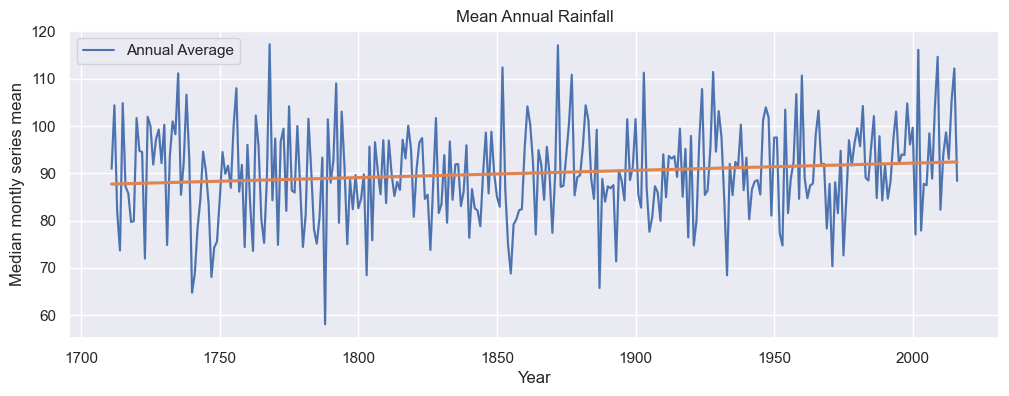

In [16]:
df_ie_rain=pd.read_csv('data/csv_files/1711_rainfall.csv')

means = df_ie_rain.groupby(['Year'])['Median montly series'].mean()
df_ie_rain = df_ie_rain.merge(right=means, left_on=['Year'], right_index=True, suffixes=('', ' mean'))

sns.set(rc = {'figure.figsize':(12, 4)})
fig, (ax) = plt.subplots()

sns.lineplot(x = 'Year', y = 'Median montly series mean', data=df_ie_rain, label = 'Annual Average')
sns.regplot(x = 'Year', y = 'Median montly series mean', scatter=False, ci=None, data=df_ie_rain)
plt.title('Mean Annual Rainfall')
plt.show()

The regression plot[16] above shows an increase in annual rainfall over the three centuries in question, next we will examine seasonal rainfall.

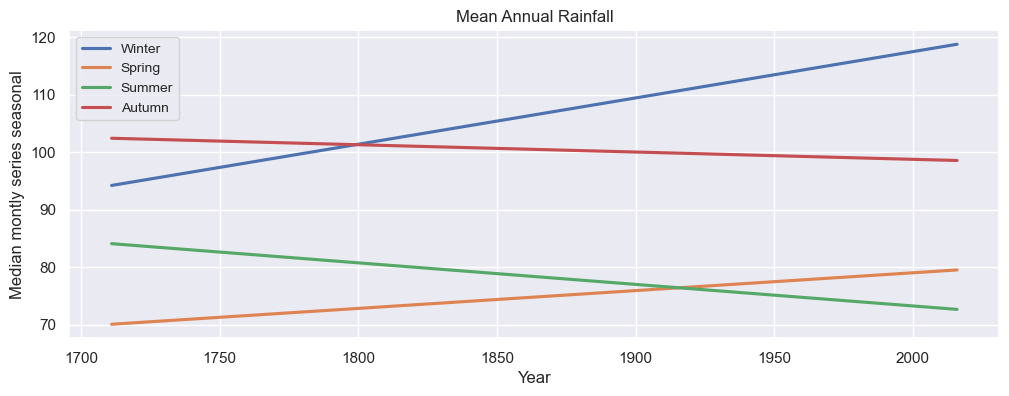

In [17]:
df_winter_rain = df_ie_rain.loc[(df_ie_rain['Month']==11)| (df_ie_rain['Month']==12)| (df_ie_rain['Month']==1)]
df_spring_rain = df_ie_rain.loc[(df_ie_rain['Month']==2)| (df_ie_rain['Month']==3)| (df_ie_rain['Month']==4)]
df_summer_rain = df_ie_rain.loc[(df_ie_rain['Month']==5)| (df_ie_rain['Month']==6)| (df_ie_rain['Month']==7)]
df_autumn_rain = df_ie_rain.loc[(df_ie_rain['Month']==8)| (df_ie_rain['Month']==9)| (df_ie_rain['Month']==10)]

# Calculate seasonal means
means = df_winter_rain.groupby(['Year'])['Median montly series'].mean()
df_winter_rain = df_winter_rain.merge(right=means, left_on=['Year'], right_index=True, suffixes=('', ' seasonal'))
means = df_spring_rain.groupby(['Year'])['Median montly series'].mean()
df_spring_rain = df_spring_rain.merge(right=means, left_on=['Year'], right_index=True, suffixes=('', ' seasonal'))
means = df_summer_rain.groupby(['Year'])['Median montly series'].mean()
df_summer_rain = df_summer_rain.merge(right=means, left_on=['Year'], right_index=True, suffixes=('', ' seasonal'))
means = df_autumn_rain.groupby(['Year'])['Median montly series'].mean()
df_autumn_rain = df_autumn_rain.merge(right=means, left_on=['Year'], right_index=True, suffixes=('', ' seasonal'))

sns.regplot(x = 'Year', y = 'Median montly series seasonal', scatter=False, ci=None, data=df_winter_rain, label = 'Winter')
sns.regplot(x = 'Year', y = 'Median montly series seasonal', scatter=False, ci=None, data=df_spring_rain, label = 'Spring')
sns.regplot(x = 'Year', y = 'Median montly series seasonal', scatter=False, ci=None, data=df_summer_rain, label = 'Summer')
sns.regplot(x = 'Year', y = 'Median montly series seasonal', scatter=False, ci=None, data=df_autumn_rain, label = 'Autumn')
plt.title('Mean Annual Rainfall')
plt.legend(fontsize=10)
plt.show()

The plot above shows an increas in rainfall during winter and spring and a reduction during the summer and autumn.

Next we will look at more data[17] from Met Éireann, this time temperature from 1900 to 2020.

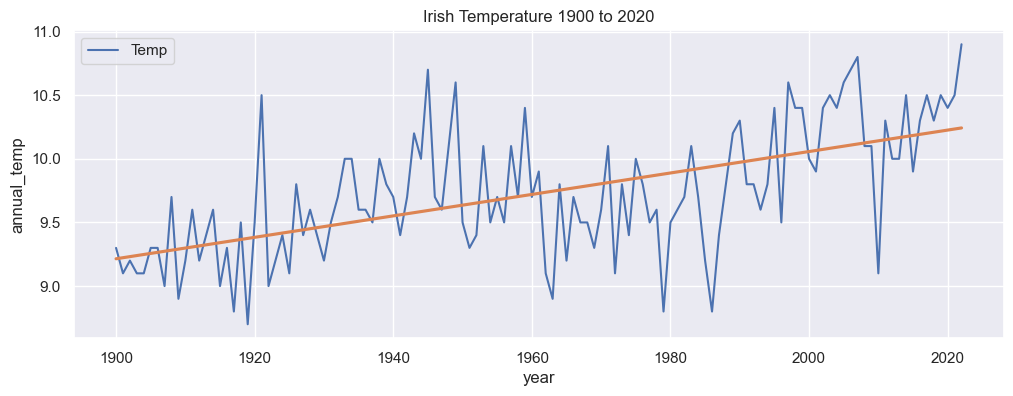

In [18]:
df_ie_temp=pd.read_csv('data/csv_files/long_term_temp_ie.csv')

sns.set(rc = {'figure.figsize':(12, 4)})
fig, ax = plt.subplots()
sns.lineplot(x = 'year', y = 'annual_temp', data=df_ie_temp, label = 'Temp')
sns.regplot(x = 'year', y = 'annual_temp', scatter=False, ci=None, data=df_ie_temp)
plt.title('Irish Temperature 1900 to 2020')
plt.show()

This plot shows circa 1&deg; of warming in 120 years.

#### Temperature Prediction for Ireland until 2100
We will use linear regression[18] on this data to predict the temperature increase[19] until 2100.

0.19505588746585523


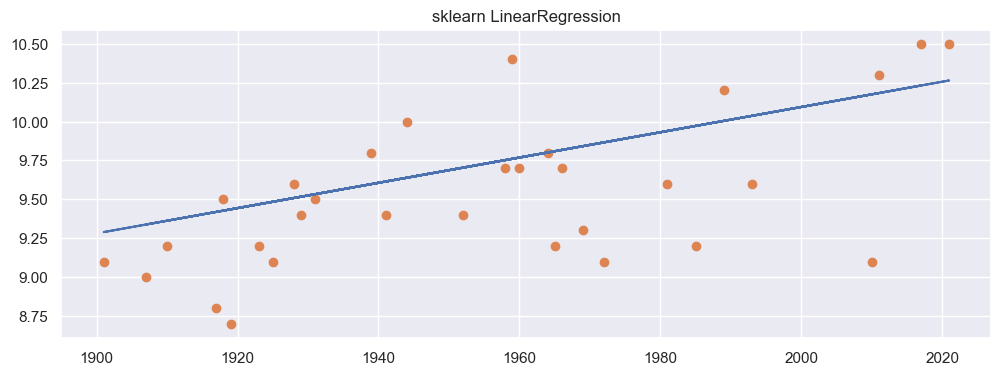

In [19]:
X = np.array(df_ie_temp['year']).reshape(-1, 1)
y = np.array(df_ie_temp['annual_temp']).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
 
regr = LinearRegression()
 
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

y_pred = regr.predict(X_test)
plt.scatter(X_test, y_test, color='#dd8452')
plt.plot(X_test, y_pred)
plt.title('sklearn LinearRegression')
plt.show()

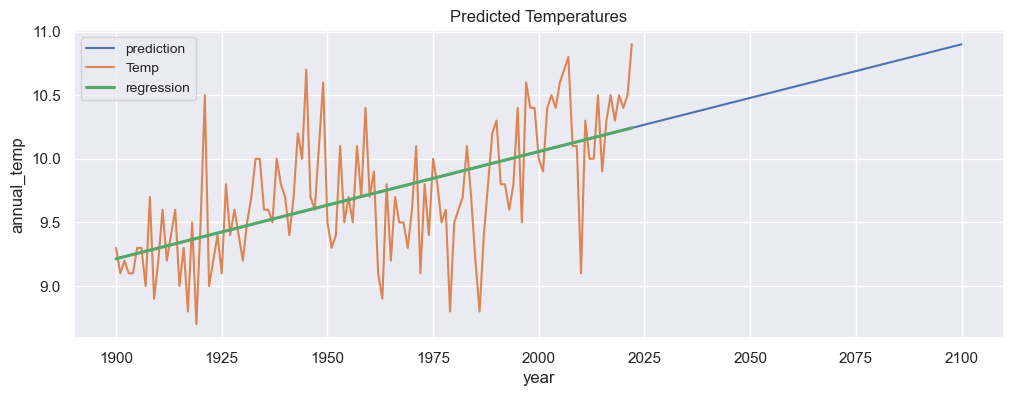

In [20]:
regr.fit(X, y)
X_200 = np.linspace(1900, 2100, 201) # 201 values between 1900 and 2100
X_200 = np.array(X_200).reshape(-1, 1)
y_pred = regr.predict(X_200)

df_pred = pd.DataFrame({'X_200': X_200[:, 0], 'y_pred': y_pred[:,0]})
 
sns.set(rc = {'figure.figsize':(12, 4)})
fig, ax = plt.subplots()

sns.lineplot(x = 'X_200', y = 'y_pred', data=df_pred, label = 'prediction')
sns.lineplot(x = 'year', y = 'annual_temp', data=df_ie_temp, label = 'Temp')
sns.regplot(x = 'year', y = 'annual_temp', scatter=False, ci=None, data=df_ie_temp, label = 'regression')
plt.legend(fontsize=10)
plt.title('Predicted Temperatures')
plt.show()

This prediction shows an increase of about 0.75&deg; of warming, however this is based a simple linear increase so may not be accurate. 

#### Instrument data
Below is a modern CO<sub>2</sub> reconstruction from the NOAA[20]. This dataset was created from measurements taken with modern instruments.

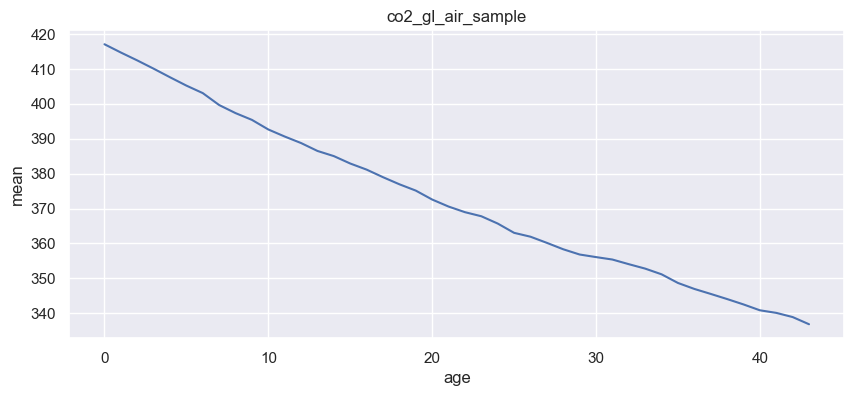

In [21]:
df_air_co2=pd.read_csv('data/csv_files/co2_gl_air_sample.csv')
df_air_co2['age'] = df_air_co2['year']
temp_column = df_air_co2['age']
def cal_age(x):
    x = 2022 - x
    return x
new_temp_column = temp_column.apply(cal_age)
df_air_co2['age'] = new_temp_column

sns.set(rc = {'figure.figsize':(10, 4)})
sns.lineplot(x = 'age', y = 'mean', data=df_air_co2)
plt.title('co2_gl_air_sample')
plt.show()

#### Fusing Data
I will merge this data with the Nature CO<sub>2</sub> Reconstruction.

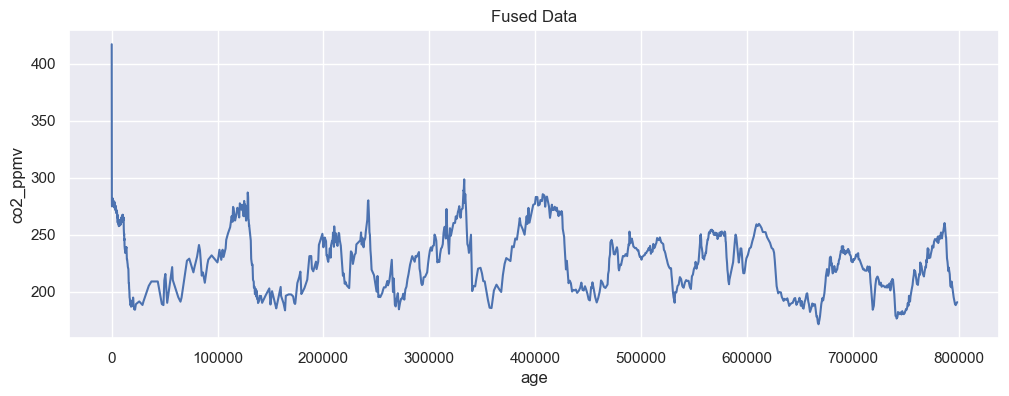

In [22]:
df_graft = df3
df_graft = pd.DataFrame().assign(age =df_graft['nature_year'], co2_ppmv = df_graft['nature_co2_ppmv'])
df_graft_2 = df_air_co2
df_graft_2 = df_graft_2.drop(['year', 'unc'], axis = 1)
df_graft_2 = df_graft_2[['age', 'mean']]
df_graft_2 = pd.DataFrame().assign(age =df_graft_2['age'], co2_ppmv = df_graft_2['mean'])
df_graft_co2 = pd.concat([df_graft, df_graft_2])

sns.set(rc = {'figure.figsize':(12, 4)})
sns.lineplot(x = 'age', y = 'co2_ppmv', data=df_graft_co2)
plt.title('Fused Data')
plt.show()

Next I will export this data in both CSV and JSON[21] formats.

In [23]:
#export as CSV
df_graft_co2.to_csv('data/csv_files/grafted_CO2_data.csv')
# export as json
df_graft_co2.to_json('data/csv_files/grafted_CO2_data.json', orient='records', lines=True)

Test exports by importing both again.

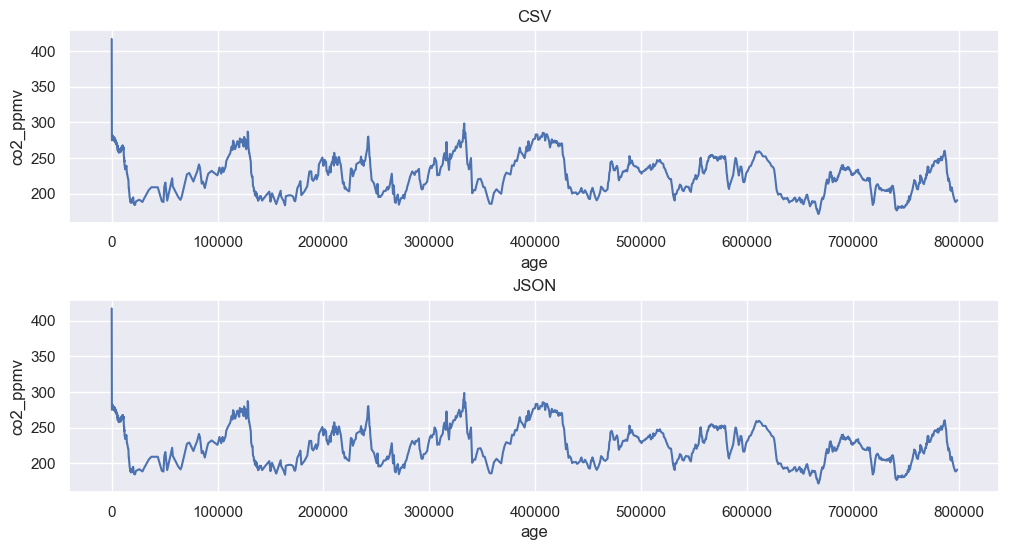

In [24]:
# test files
df_csv=pd.read_csv('data/csv_files/grafted_CO2_data.csv')
df_json=pd.read_json('data/csv_files/grafted_CO2_data.json', lines=True)

sns.set(rc = {'figure.figsize':(12, 6)})
fig, (ax1, ax2) = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
sns.lineplot(x = 'age', y = 'co2_ppmv', data=df_csv, ax = ax1).set(title='CSV')
sns.lineplot(x = 'age', y = 'co2_ppmv', data=df_json, ax = ax2).set(title='JSON')
plt.show()

#### Sea Ice Data
Next I will look at Sea Ice extent data from Copernicus[22].

This data is in netCDF[7] format, to install netCDF run the following:
conda install -c conda-forge netCDF4
To open a netCDF4 file in Pandas[23] uncomment the code below.


In [25]:
'''
# Reading netCDF file
ds = xr.open_dataset('data/arctic_omi_si_extent_19930115_P20220328.nc')
# df_si = ds.to_dataframe()
# export as CSV
# df_si.to_csv('data/csv_files/sea_ice.csv')
'''

"\n# Reading netCDF file\nds = xr.open_dataset('data/arctic_omi_si_extent_19930115_P20220328.nc')\n# df_si = ds.to_dataframe()\n# export as CSV\n# df_si.to_csv('data/csv_files/sea_ice.csv')\n"

The plots below shows montly sea ice from 1993 to 2019

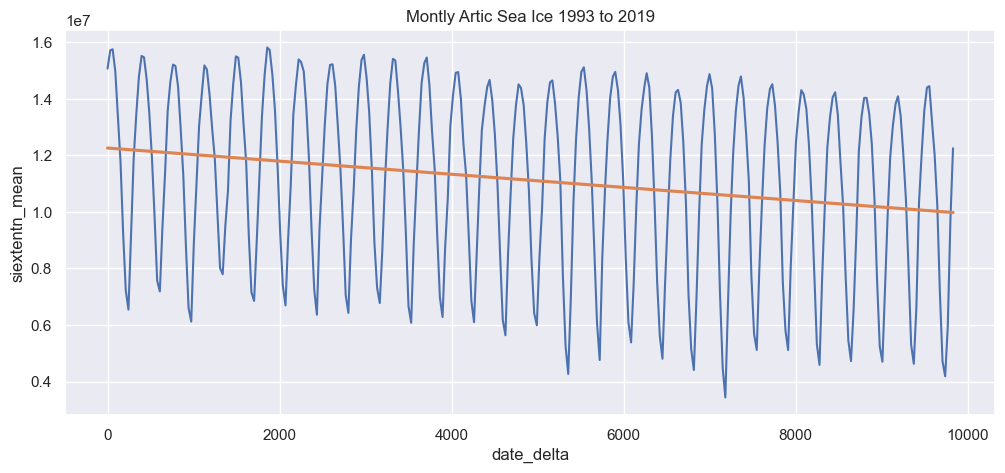

In [26]:
df_si = pd.read_csv('data/csv_files/sea_ice.csv')
# Using pandas.to_datetime() to convert pandas column to DateTime
df_si['time series'] = pd.to_datetime(df_si['time'], format = '%d/%m/%Y')
df_si['date_delta'] = (df_si['time series'] - df_si['time series'].min())  / np.timedelta64(1,'D')

sns.set(rc = {'figure.figsize':(12, 5)})
fig, (ax) = plt.subplots(sharex=False)

sns.lineplot(x = 'date_delta', y = 'siextentn_mean', data=df_si).set(title='Montly Artic Sea Ice 1993 to 2019')
sns.regplot(x = 'date_delta', y = 'siextentn_mean', ci=None, scatter=False, dropna=False, data=df_si)
plt.show()

Below is the yearly sea ice extent

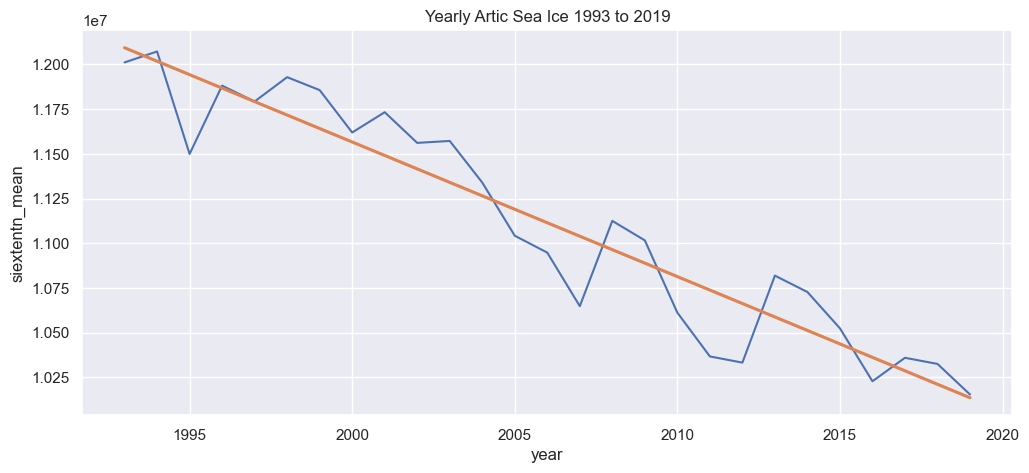

In [27]:
y = pd.to_datetime(df_si['time'], format = '%d/%m/%Y').dt.year.rename('year')
df_yearly_si = df_si.groupby(y)['siextentn_mean'].mean().reset_index()
sns.lineplot(x = 'year', y = 'siextentn_mean', data=df_yearly_si).set(title='Yearly Artic Sea Ice 1993 to 2019')
sns.regplot(x = 'year', y = 'siextentn_mean', scatter=False, ci=None, data=df_yearly_si)
plt.show()

#### Acceleration

Finally I will split the sea ice extent into four parts to see if I can find any evidence of acceleration in loss of sea ice.

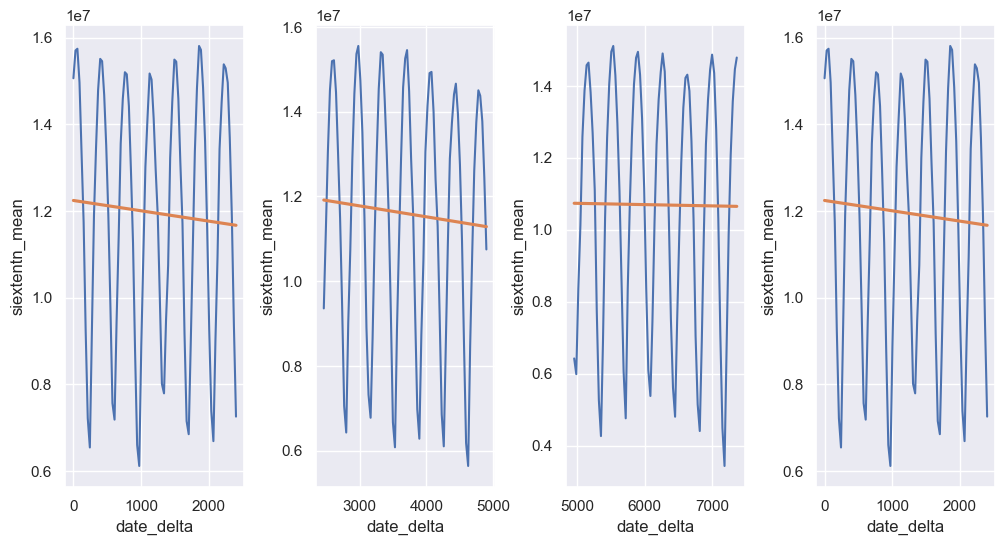

In [28]:
df_si['siextentn_mean'] = pd.to_numeric(df_si['siextentn_mean'])
df_si['date_delta'] = pd.to_numeric(df_si['date_delta'])

df_si1 = df_si[0:80]
df_si2 = df_si[81:162]
df_si3 = df_si[163:243]
df_si4 = df_si[244:323]

sns.set(rc = {'figure.figsize':(12, 6)})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharex=False)
fig.subplots_adjust(wspace=0.4)
sns.lineplot(x = 'date_delta', y = 'siextentn_mean', data=df_si1, ax=ax1)
sns.regplot(x = 'date_delta', y = 'siextentn_mean', ci=None, scatter=False, dropna=False, data=df_si1, ax=ax1)
sns.lineplot(x = 'date_delta', y = 'siextentn_mean', data=df_si2, ax=ax2)
sns.regplot(x = 'date_delta', y = 'siextentn_mean', ci=None, scatter=False, dropna=False, data=df_si2, ax=ax2)
sns.lineplot(x = 'date_delta', y = 'siextentn_mean', data=df_si3, ax=ax3)
sns.regplot(x = 'date_delta', y = 'siextentn_mean', ci=None, scatter=False, dropna=False, data=df_si3, ax=ax3)
sns.lineplot(x = 'date_delta', y = 'siextentn_mean', data=df_si1, ax=ax4)
sns.regplot(x = 'date_delta', y = 'siextentn_mean', ci=None, scatter=False, dropna=False, data=df_si1, ax=ax4)
plt.show()

I don't see any evidence of acceleration in these plots but it is a very short time line so it's possible that evidence of acceleration would be present in a longer timeline.


## References
***
[1]	“Pachauri et al. - 2015 - Climate change 2014 synthesis report.pdf.” Accessed: Jan. 10, 2024. [Online]. Available: https://epic.awi.de/id/eprint/37530/1/IPCC_AR5_SYR_Final.pdf

[2]	“Evidence | Facts – Climate Change: Vital Signs of the Planet.” Accessed: Jan. 10, 2024. [Online]. Available: https://climate.nasa.gov/evidence/

[3]	J. A. Church et al., “Sea level change,” P.M.Cambridge University Press, Technical Report, 2013. Accessed: Jan. 10, 2024. [Online]. Available: https://drs.nio.res.in/drs/handle/2264/4605

[4]	E.-G. Beck, “50 YEARS OF CONTINUOUS MEASUREMENT OF CO2 ON MAUNA LOA,” vol. 19, no. 7, 2008.

[5]	“MLO Station Data | Scripps CO2 Program.” Accessed: Jan. 10, 2024. [Online]. Available: https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html

[6]	“Xlrd :: Anaconda.org.” Accessed: Jan. 10, 2024. [Online]. Available: https://anaconda.org/anaconda/xlrd

[7]	“netCDF4 API documentation.” Accessed: Jan. 10, 2024. [Online]. Available: https://unidata.github.io/netcdf4-python/

[8]	D. Luthi et al., “High-resolution carbon dioxide concentration record 650,000–800,000 years before present,” vol. 453, 2008.

[9]	D. Chen et al., “Framing, Context, and Methods (Chapter 1),” V. Masson-Delmotte, P. Zhai, A. Pirani, S. L. Connors, C. Péan, S. Berger, N. Caud, Y. Chen, L. Goldfarb, M. I. Gomis, M. Huang, K. Leitzell, E. Lonnoy, J. B. R. Matthews, T. K. Maycock, T. Waterfield, K. Yelekçi, R. Yu, and B. Zhu, Eds., Cambridge, United Kingdom and New York, NY, USA: Cambridge University Press, 2021, pp. 147–286. Accessed: Jan. 10, 2024. [Online]. Available: https://www.ipcc.ch/report/ar6/wg1/

[10]	J. Jouzel et al., “Orbital and Millennial Antarctic Climate Variability over the Past 800,000 Years,” vol. 317, 2007.

[11]	L. Bazin et al., “An optimized multi-proxy, multi-site Antarctic ice and gas orbital chronology (AICC2012): 120–800 ka,” Clim. Past, vol. 9, no. 4, pp. 1715–1731, 2013.

[12]	“CO2 lags temperature - what does it mean?” Accessed: Jan. 11, 2024. [Online]. Available: https://skepticalscience.com/co2-lags-temperature-advanced.htm

[13]	T. F. Stocker et al., “Climate Change 2013: The physical science basis. contribution of working group I to the fifth assessment report of IPCC the intergovernmental panel on climate change,” 2014, Accessed: Jan. 11, 2024. [Online]. Available: https://boris.unibe.ch/71452/

[14]	J. Chappellaz, J. M. Barnola, D. Raynaud, Y. S. Korotkevich, and C. Lorius, “Ice-core record of atmospheric methane over the past 160,000 years,” Nature, vol. 345, no. 6271, pp. 127–131, 1990.

[15]	“Long Term Data Sets - Met Éireann - The Irish Meteorological Service.” Accessed: Jan. 11, 2024. [Online]. Available: https://www.met.ie/climate/available-data/long-term-data-sets/

[16]	“seaborn.regplot — seaborn 0.13.1 documentation.” Accessed: Jan. 11, 2024. [Online]. Available: https://seaborn.pydata.org/generated/seaborn.regplot.html

[17]	“Temperature - Met Éireann - The Irish Meteorological Service.” Accessed: Jan. 11, 2024. [Online]. Available: https://www.met.ie/climate/what-we-measure/temperature

[18]	“sklearn.linear_model.LinearRegression — scikit-learn 1.3.2 documentation.” Accessed: Jan. 11, 2024. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

[19]	“Python | Linear Regression using sklearn - GeeksforGeeks.” Accessed: Jan. 11, 2024. [Online]. Available: https://www.geeksforgeeks.org/python-linear-regression-using-sklearn/

[20]	“Global Monitoring Laboratory - Carbon Cycle Greenhouse Gases.” Accessed: Jan. 11, 2024. [Online]. Available: https://gml.noaa.gov/ccgg/trends/gl_data.html

[21]	“pandas.DataFrame.to_json — pandas 2.1.4 documentation.” Accessed: Jan. 11, 2024. [Online]. Available: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_json.html

[22]	“Arctic Monthly Mean Sea Ice Extent from Observations Reprocessing | Copernicus Marine MyOcean Viewer.” Accessed: Jan. 11, 2024. [Online]. Available: https://data.marine.copernicus.eu/product/ARCTIC_OMI_SI_extent_obs/files?subdataset=arctic_omi_si_extent_obs_202311

[23]	“python - Import netCDF file to Pandas dataframe - Stack Overflow.” Accessed: Jan. 11, 2024. [Online]. Available: https://stackoverflow.com/questions/14035148/import-netcdf-file-to-pandas-dataframe

***
## End